# UAVSAR

<img src="../../img/uavsar_title_figure.png" alt="uavsar scene" width="800px">

```{admonition} Learning Objectives
*A 30 minute guide to UAVSAR data for SnowEX*
- What is UAVSAR?
- Why would I use UAVSAR?
- How can I access UAVSAR imagery?
- What are the UAVSAR data products?
- UAVSAR Snow water equivalent inversion
```

*Developers: \
Jack Tarricone, University of Nevada, Reno \
Zach Keskinen, Boise State University*

*Other developers: \
Ross Palomaki, Montana State University\
Naheem Adebisi, Boise State University*

#### Import Relevant Libraries

In [33]:
import sys
import os
import glob
import xarray as xr
import rioxarray as rxr
import earthpy.plot as ep
import numpy as np
import uavsar_pytools
import matplotlib.pyplot as plt
import matplotlib
import rasterio as rio
from osgeo import gdal
from rasterio.plot import show

## What is UAVSAR?

<img src="../../img/UAVSAR_plane.jpeg" alt="uavsar scene" width="800px">

UAVSAR stands for uninhabited aerial vehicle synthetic aperture radar. It is a suborbital (airplane) remote sensing instrument operated out of NASA JPL.

| frequency (cm) | resolution (rng x azi m) | swath width (km) |
| - | - | - | 
| L-band 23| 1.8 x 5.5 | 16 | 

Documentation:
* https://uavsar.jpl.nasa.gov/education/what-is-uavsar.html
* https://asf.alaska.edu/data-sets/sar-data-sets/uavsar/
* https://ieeexplore-ieee-org.unr.idm.oclc.org/document/1631770 (Rosen et al. 2006)


## Why would I use UAVSAR?

UAVSAR works with low frequency radar waves. This means it is unaffected by clouds, maintains coherence, a measure of radar image quality, over long periods, and a time series was captured over 13 sites as part of the winter of 2019-2020 and 2020-2021. Additionally the 

## NASA SnowEx 2020 and 2021 UAVSAR Campaings

During the winter of 2020 and 2021, NASA conducted an L-band InSAR timeseris at a seris of sites across the Western US with the goal of tracking changes in SWE. Field teams in 13 different locations in 2020, and in 6 locations in 2021, deployed on the date of the flight to perform calibration and validation observations.

:::{figure-md} UAVSAR-map
<img src="../../img/SnowEx_map.jpg" alt="uavsar map" width="800px">

Map of the UAVSAR flight locations for NASA SnowEx. Source: Chris Hiemstra
:::

## Data Access

There are multiple ways to access UAVSAR data. Also the SQL database.

* [JPL UAVSAR Data Search](https://uavsar.jpl.nasa.gov/cgi-bin/data.pl)
* [Alaska Satellite Facility Vertex Portal](https://search.asf.alaska.edu/#/?dataset=UAVSAR)

```{admonition} InSAR Data Types
:class: InSAR Data Types
- ANN file (.ann): a text annotation file with metadata
- AMP files (.amp1 and .amp2): calibrated multi-looked amplitude products
- INT files (.int): interferogram product, complex number format (we won't be using these here)
- COR files (.cor): interferometric correlation product, a measure of the noise level of the phase
- GRD files (.grd): interferometric products projected to the ground in simple geographic coordinates (latitude, longitude)
- HGT file  (.hgt): the DEM that was used in the InSAR processing
- KML and KMZ files (.kml or .kmz): format for viewing files in Google Earth (can't be used for analysis)
```

## Data Download and Conversion with ```uavsar_pytools```
```uavsar_pytools``` is a Python package developed out of work started at SnowEx Hackweek 2021. It nativiely downloads, formats, and converts this data in analysis ready rasters projected in WSG-84 Lat/Lon (maybe more infor here). The data traditionally comes in a binary format, which is not injestible by tradtional geospatial analysis software (Python, R, QGIS, ArcGIS). 


To use it, you just need to input a url into the ```UavsarImage``` function, and a path to where you want the data output to be. Once that object is created, use the ```url_to_tiffs``` funciton to begin the process. Data has to download, but there's a progress bar to keep tabs. Once the data is downloaded the conversion happens within a miniute or so.

Or you can use https://search.asf.alaska.edu/ to find a url through their vertex interface.

In [2]:
# import function
from uavsar_pytools import UavsarImage

# set path to saving location
saving_location = '/Users/jacktarricone/hackweek2022/tutorial_data/'

### Download unwrapped phase (.unw) data

In [ ]:
# set file path unwrapped phase data
unw_image = 'http://uavsar.asfdaac.alaska.edu/UA_lowman_23205_21002-004_21004-003_0005d_s01_L090_01/lowman_23205_21002-004_21004-003_0005d_s01_L090HH_01.unw.grd'

In [ ]:
# run function
image = UavsarImage(url = unw_image, work_dir = saving_location)
image.url_to_tiff()

In [ ]:
# test plot
image.show()

### Download coherence (.cor) data

In [ ]:
# set file path
cor_image = 'http://uavsar.asfdaac.alaska.edu/UA_lowman_23205_21002-004_21004-003_0005d_s01_L090_01/lowman_23205_21002-004_21004-003_0005d_s01_L090HH_01.cor.grd'

In [ ]:
# run function
image2 = UavsarImage(url = cor_image, work_dir = './data/imgs/')
image2.url_to_tiff()

In [ ]:
# test plot
image2.show()

There is also functionality within called ```UavsarScence```, which can download zip files of interferometric data. While we won't use it here, it's useful for bulk downloading. 

In [ ]:
# download and convert data
# from uavsar_pytools import UavsarScene
# scene = UavsarScene(url = path_to_zip, work_dir = saving_location)
# scene.url_to_tiffs()

## Plotting the data

In [3]:
# set working directory
os.chdir(saving_location)

# unwrapped phase
for unw in glob.glob('*unw.grd.tiff'):
    print(unw)
    
# coherence
for cor in glob.glob('*cor.grd.tiff'):
    print(cor)

lowman_23205_21002-004_21004-003_0005d_s01_L090HH_01.unw.grd.tiff
lowman_23205_21002-004_21004-003_0005d_s01_L090HH_01.cor.grd.tiff


In [4]:
# open raster and inspect meta data using xarray
unw_rast  = rxr.open_rasterio(unw)
unw_rast

<xarray.DataArray (band: 1, y: 16064, x: 24968)>
[401085952 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -116.4 -116.4 -116.4 ... -115.0 -115.0 -115.0
  * y            (y) float64 44.49 44.49 44.49 44.49 ... 43.59 43.59 43.59 43.59
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [5]:
# get extent 
bounds = unw_rast.rio.bounds()
print(bounds)

(-116.37414252, 43.59315383999999, -114.98692044000002, 44.48566968)


In [6]:
# convert to np.array for plotting
unw_array = unw_rast[0].values
unw_array

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

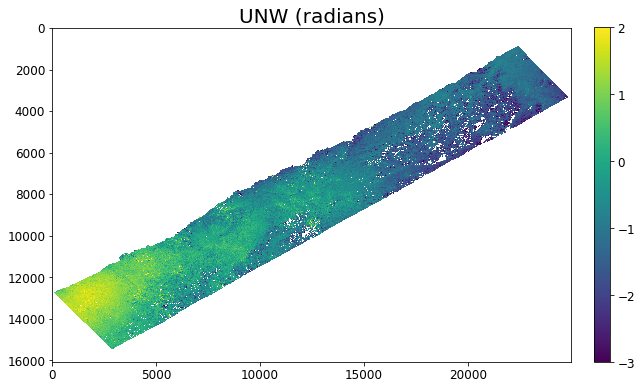

In [16]:
# plot
plt.rcParams.update({'font.size': 12}) # increase plot font size for larger plot
fig, ax = plt.subplots(figsize=(10, 20))

ax.set_title("UNW (radians)", fontsize= 20) #title and font size
img = ax.imshow(unw_array, interpolation = 'nearest', cmap = 'viridis', vmin = -3, vmax = 2)

# add legend
colorbar = fig.colorbar(img, ax=ax, fraction=0.03, pad=0.04) # add color bar
plt.show()

In [11]:
# open raster and inspect meta data
cor_rast  = rxr.open_rasterio(cor)
cor_rast

<xarray.DataArray (band: 1, y: 16064, x: 24968)>
[401085952 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -116.4 -116.4 -116.4 ... -115.0 -115.0 -115.0
  * y            (y) float64 44.49 44.49 44.49 44.49 ... 43.59 43.59 43.59 43.59
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [12]:
# convert to np.array for plotting
cor_array = cor_rast[0].values

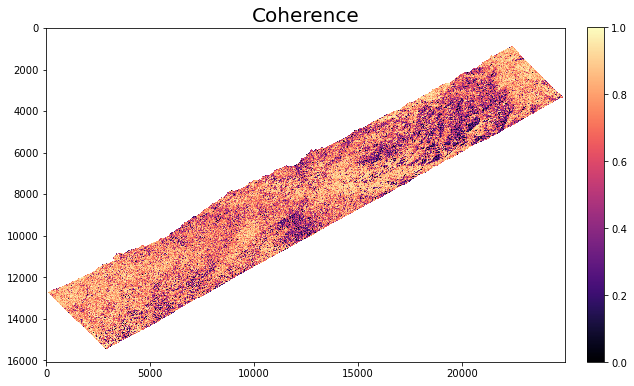

In [13]:
# plot
fig, ax = plt.subplots(figsize=(10, 20))
ax.set_title("Coherence", fontsize= 20) #title and font size
img = ax.imshow(cor_array, cmap = 'magma', interpolation = 'nearest', vmin = 0, vmax = 1)

# add legend
colorbar = fig.colorbar(img, ax=ax, fraction=0.03, pad=0.04) # add color bar
plt.show()

## Radar vs. Optical Imagery

In [44]:
# unwrapped phase
os.chdir('/Users/jacktarricone/hackweek2022/tutorial_data/hls/')

# define red path
for rgb in glob.glob('*rgb.tif'):
    print(rgb)

# read in
hls_rast = rxr.open_rasterio(rgb)
hls_rast

banner_hls_rgb.tif


<xarray.DataArray (band: 3, y: 3660, x: 3660)>
[40186800 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 6e+05 6e+05 6.001e+05 ... 7.098e+05 7.098e+05
  * y            (y) float64 5e+06 5e+06 5e+06 ... 4.89e+06 4.89e+06 4.89e+06
    spatial_ref  int64 0
Attributes:
    STATISTICS_MAXIMUM:  1.5656
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  -0.1913
    STATISTICS_STDDEV:   -9999
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           ('Blue', 'Green', 'Red')

AttributeError: 'tuple' object has no attribute 'startswith'

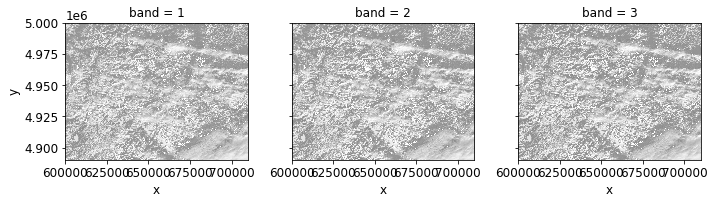

In [48]:
hls_rast.plot.imshow(col="band",
                     cmap="Greys_r")
plt.show()

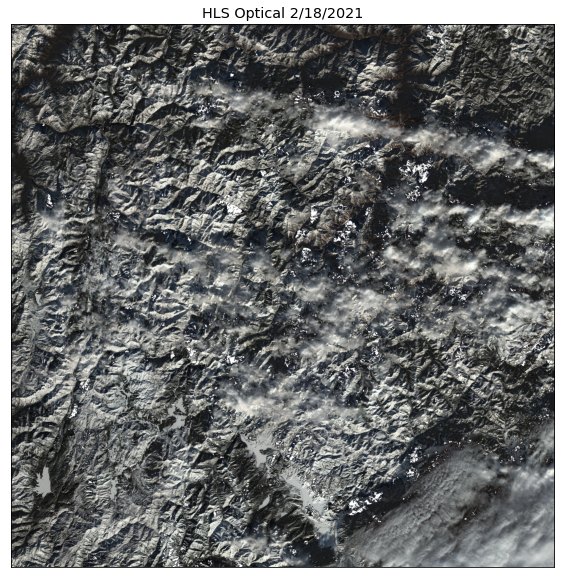

In [51]:
ep.plot_rgb(hls_rast.values,
            rgb = [2, 1, 0],
            title = "HLS Optical 2/18/2021")
plt.show()